In [27]:
import numpy as np
import pandas as pd
from pathlib import Path
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller
import itertools
import datetime
import warnings
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import seaborn as sns



import warnings

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

In [28]:
df = pd.read_excel("D://Khalid//Magang//PELNI_RevenueRegression//Revenue-Regression//revenueDaily.xlsx")
df = df.rename(columns={'tanggal': 'date'})
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df.rename(columns={'penghasilan_muatan': 'y'}) #RENAME KOLOM REVENUE MENJADI y
# df = df.astype({'y':'int'})
# df = df.set_index('date')
# df = df.sort_index()
df

,y,date,org,kode_org,des,kode_des
0,1014634.0,2023-01-18,AGATS,948,BAU-BAU,921
1,62486.0,2023-01-13,AGATS,948,KUPANG,681
2,1232000.0,2022-02-16,AGATS,948,MAKASSAR,893
3,344312.0,2023-02-11,AGATS,948,MERAUKE,979
4,344312.0,2023-01-18,AGATS,948,MERAUKE,979
...,...,...,...,...,...,...
21225,2324074.0,2022-09-24,WASIOR,981,TANJUNG PRIOK,431
21226,3600595.0,2023-03-26,WASIOR,981,TANJUNG PRIOK,431
21227,2324073.0,2023-02-26,WASIOR,981,TANJUNG PRIOK,431
21228,2325000.0,2022-01-01,WASIOR,981,TANJUNG PRIOK,431


In [29]:
data = df.loc[:,['date', 'y']]
data

,date,y
0,2023-01-18,1014634.0
1,2023-01-13,62486.0
2,2022-02-16,1232000.0
3,2023-02-11,344312.0
4,2023-01-18,344312.0
...,...,...
21225,2022-09-24,2324074.0
21226,2023-03-26,3600595.0
21227,2023-02-26,2324073.0
21228,2022-01-01,2325000.0


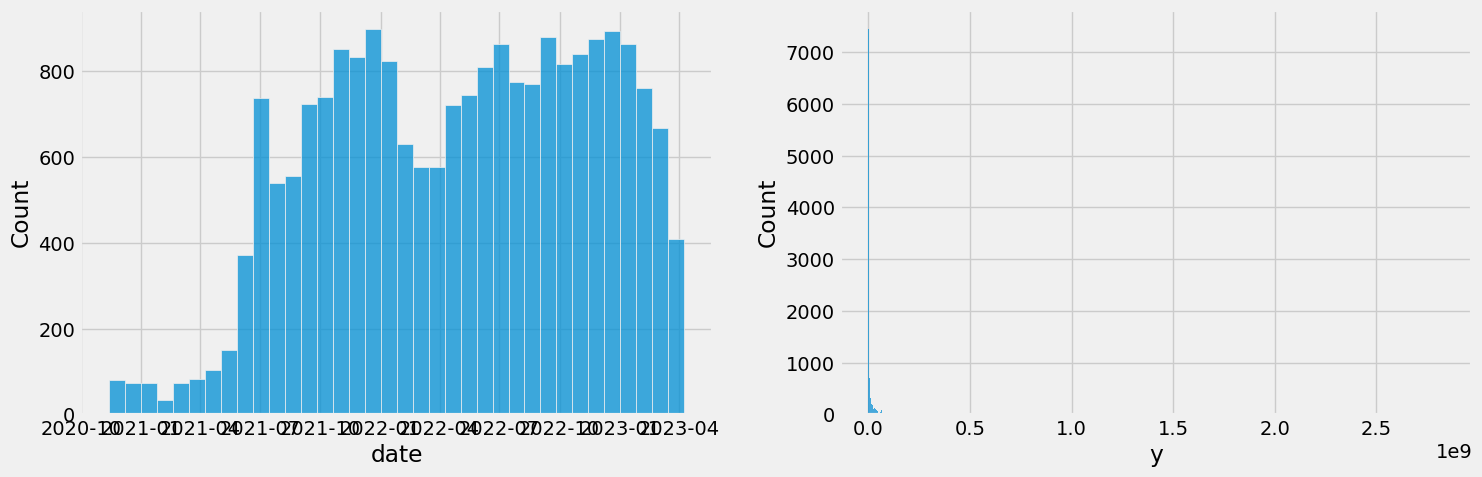

In [30]:
# Plot the distribution plot for the features
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.histplot(data['date'])
plt.subplot(1,2,2)
sns.histplot(data['y'])
plt.show()

<Axes: >

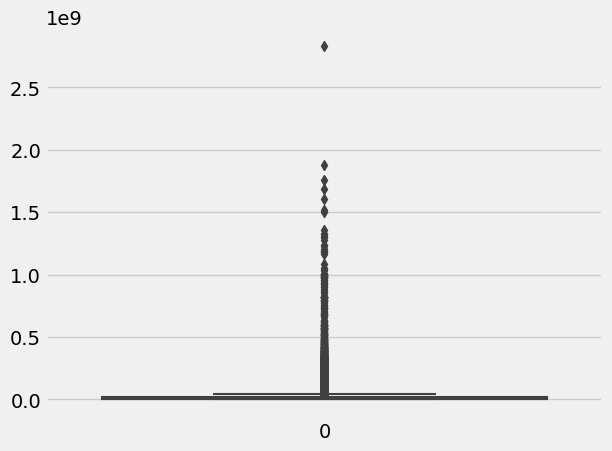

In [31]:
# Form a box-plot for the skewed feature
sns.boxplot(data['y'])

In [32]:
# Finding the IQR
percentile25 = data['y'].quantile(0.25)
percentile75 = data['y'].quantile(0.75)

In [33]:
# Finding the upper and lower limits
iqr = percentile75 - percentile25
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

In [34]:
# Finding outliers
data[data['y'] > upper_limit]
data[data['y'] < lower_limit]

,date,y


In [35]:
# Trimming outliers
new_df = data[data['y'] < upper_limit]
new_df.shape

(18270, 2)

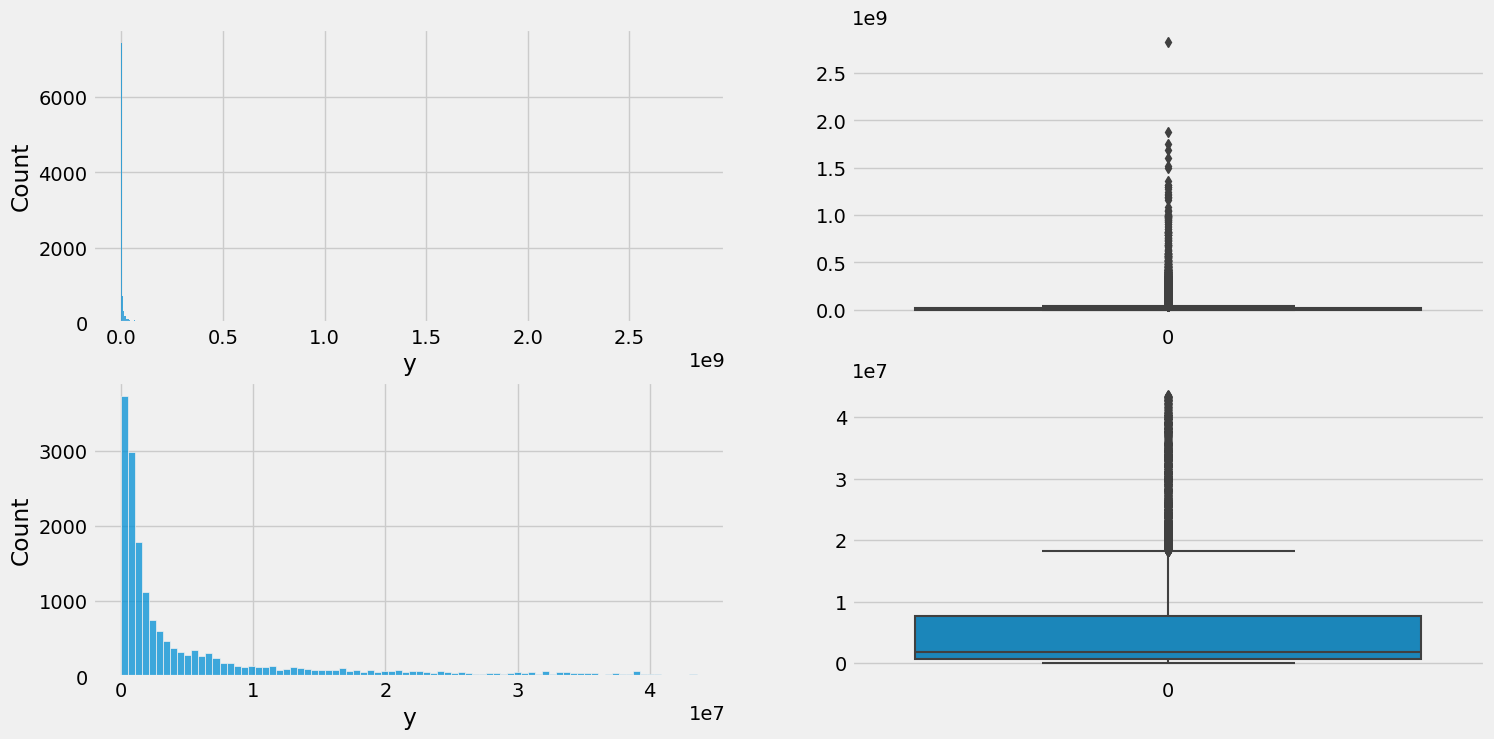

In [36]:
# Trimming outliers
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.histplot(data['y'])
plt.subplot(2,2,2)
sns.boxplot(data['y'])
plt.subplot(2,2,3)
sns.histplot(new_df['y'])
plt.subplot(2,2,4)
sns.boxplot(new_df['y'])
plt.show()

In [40]:
# Capping
new_df_cap = data.copy()
new_df_cap['y'] = np.where(
    new_df_cap['y'] > upper_limit,
    upper_limit,
    np.where(
        new_df_cap['y'] < lower_limit,
        lower_limit,
        new_df_cap['y']))

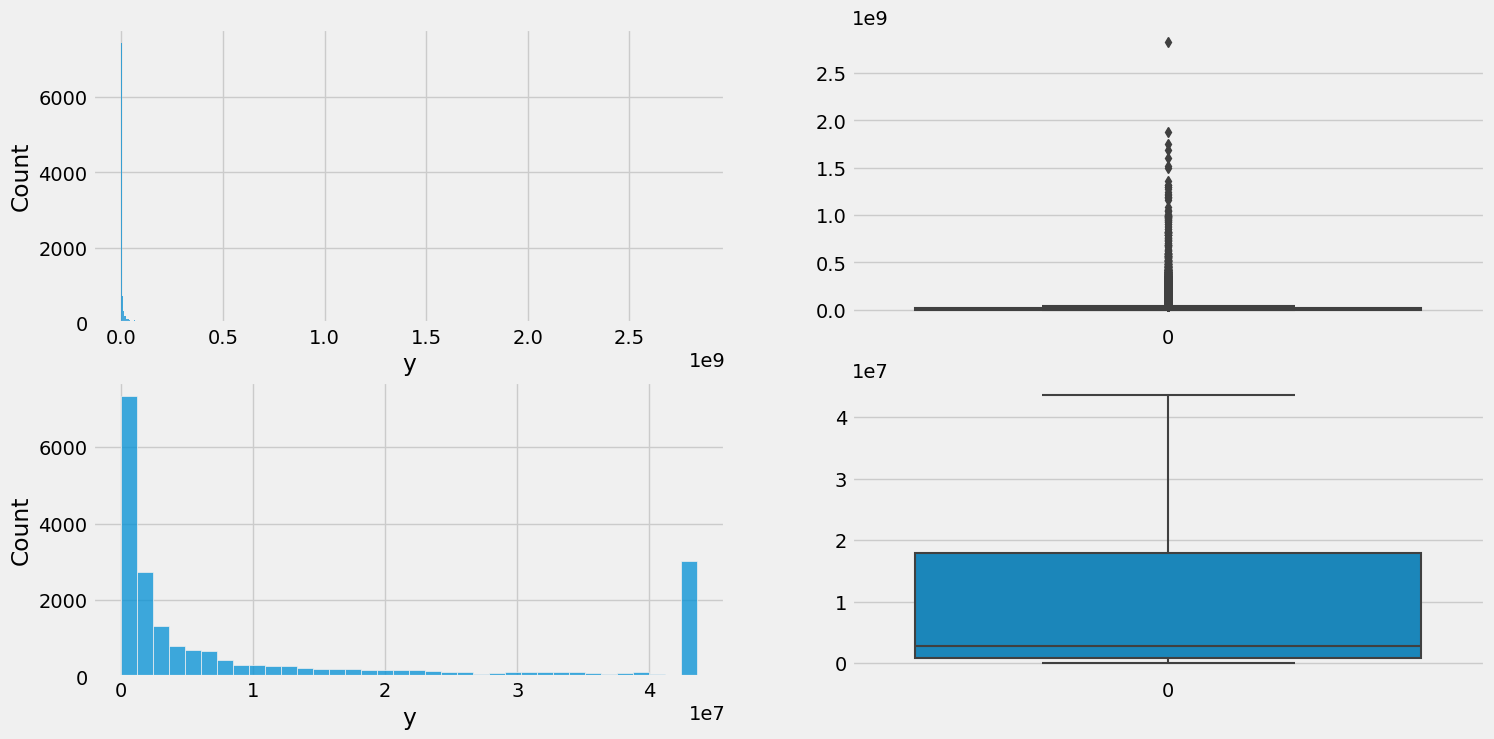

In [41]:
# Compare the plots after capping
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.histplot(data['y'])
plt.subplot(2,2,2)
sns.boxplot(data['y'])
plt.subplot(2,2,3)
sns.histplot(new_df_cap['y'])
plt.subplot(2,2,4)
sns.boxplot(new_df_cap['y'])
plt.show()

In [42]:
print("Min - Max Value :",min(new_df_cap['y']),"-",max(new_df_cap['y']))
new_df_cap

Min - Max Value : 685.0 - 43578422.75


,date,y
0,2023-01-18,1014634.0
1,2023-01-13,62486.0
2,2022-02-16,1232000.0
3,2023-02-11,344312.0
4,2023-01-18,344312.0
...,...,...
21225,2022-09-24,2324074.0
21226,2023-03-26,3600595.0
21227,2023-02-26,2324073.0
21228,2022-01-01,2325000.0


In [48]:
# forward-fill missing values | Interpolate
new_df_cap['y'].fillna(method='ffill', inplace=True)
print(f'Number of rows with missing values: {new_df_cap.isnull().mean()}')


Number of rows with missing values: date    0.0
y       0.0
dtype: float64


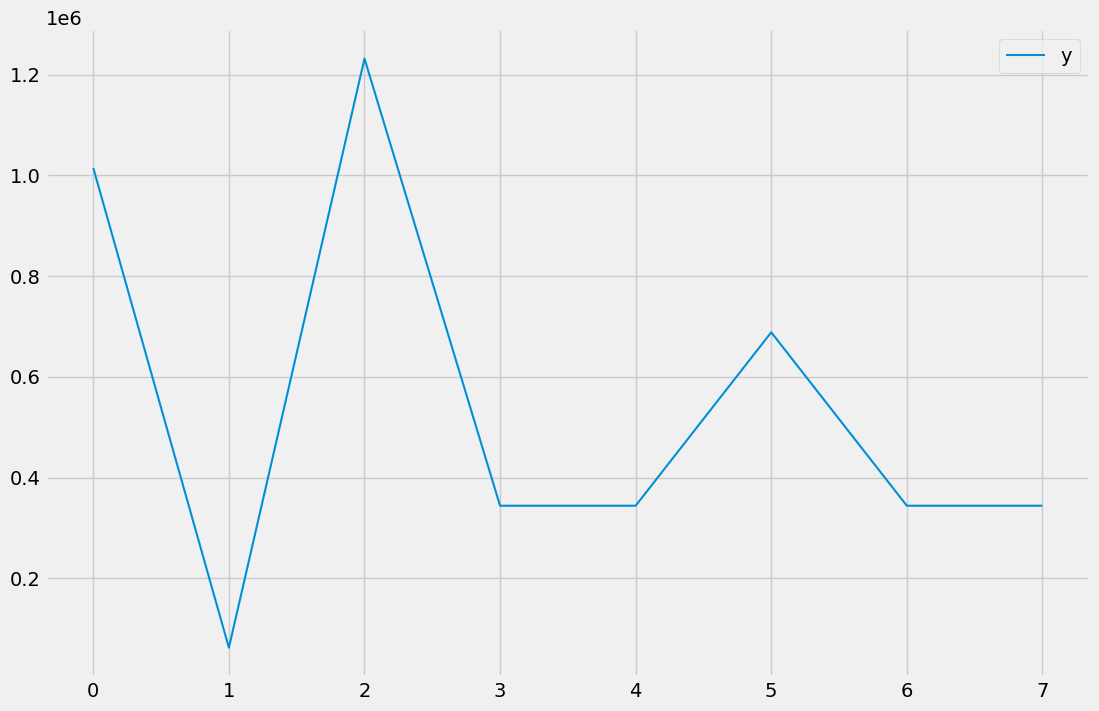

In [49]:
revenue_plot = new_df_cap['y'].iloc[0:8].plot(
    figsize=(12,8),
    legend=True,
)

In [50]:
#Standar Scaler
#Standardize features by removing the mean and scaling to unit variance.

unscaled = new_df_cap['y'].values.reshape(len(new_df_cap['y']),1)
scaler = StandardScaler()
scaler.fit(unscaled)
scaled = scaler.transform(unscaled)
new_df_cap['y'] = scaled
new_df_cap['y']

0       -0.682679
1       -0.743496
2       -0.668795
3       -0.725495
4       -0.725495
           ...   
21225   -0.599042
21226   -0.517507
21227   -0.599042
21228   -0.598982
21229   -0.450596
Name: y, Length: 21230, dtype: float64

Train dates : 0 --- 21224  (n=21225)
Test dates  : 21225 --- 21229  (n=5)


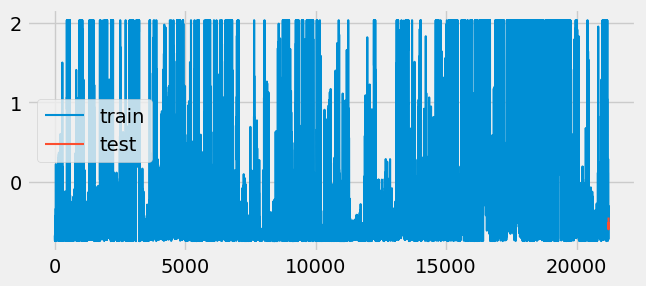

In [51]:
steps = 5
data_train = new_df_cap[:-steps]
data_test  = new_df_cap[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax = plt.subplots(figsize=(7, 3))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
ax.legend()

In [52]:
#CARI BEST HPO PAKAI GRIDSEARCH + MASUKIN KE MODEL ARIMA

import warnings
p_values = range(0, 6)
d_values = range(0, 3)
q_values = range(0, 3)

# Ignore the convergence warnings
warnings.filterwarnings("ignore")

# Grid search over all combinations of p, d, and q
best_rmse, best_order = float('inf'), None
for p, d, q in itertools.product(p_values, d_values, q_values):
        print(p,d,q)

        # Fit the ARIMA model to the training data
        model = ARIMA(data_train['y'].values,order=(p,q,d))
        model_fit = model.fit()

        # Make predictions on the test data
        predictions = pd.DataFrame(model_fit.forecast(steps=steps),columns=['prediction'])
        predictions.index = data_test.index


        # Calculate the RMSE of the predictions
        rmse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions['prediction']
            )
        print(rmse)

        # Check if this is the best model so far
        if rmse < best_rmse:
            best_rmse = rmse
            best_order = (p, d, q)

0 0 0
0.3096048289982211
0 0 1
0.004416128290054587
0 0 2
0.5312982982903891
0 1 0
0.2685828783692755
0 1 1
0.0071634623566297255
0 1 2
0.004416397572819832
0 2 0
0.25164729755042564
0 2 1
0.007158003149026847
0 2 2
0.007070504926078173
1 0 0
0.15012184151950891
1 0 1
0.016215628759763217
1 0 2
0.013261972666269151
1 1 0
0.012229159020382048
1 1 1
0.007157982972568979
1 1 2
0.016219549221283984
1 2 0
0.012285521185082547
1 2 1
0.0072161393064800895
1 2 2
0.007040594064351091
2 0 0
0.08319469534648592
2 0 1
0.010989237202074977
2 0 2
0.01406311428145865
2 1 0
0.012289772843121298
2 1 1
0.007166145428988716
2 1 2
0.010995969876996872
2 2 0
0.012342390319050893
2 2 1
0.007212626939690886
2 2 2
0.007052401567005066
3 0 0
0.04656164869613006
3 0 1
0.01154043701224069
3 0 2
0.007048406244665675
3 1 0
0.012305615971124687
3 1 1
0.007112278184588308
3 1 2
0.011545076043896856
3 2 0
0.012353335575704548
3 2 1
0.007190671308310817
3 2 2
0.007045625411024997
4 0 0
0.03378664192899726
4 0 1
0.0128

In [53]:
print(best_rmse,(best_order))
arima_model = ARIMA(data_train['y'].values,order=(best_order))
arima_results = arima_model.fit()
# Output model summary results:
arima_results.summary()

0.004416128290054587 (0, 0, 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                21225
Model:                 ARIMA(0, 0, 1)   Log Likelihood              -26925.166
Date:                Mon, 24 Apr 2023   AIC                          53856.331
Time:                        09:13:59   BIC                          53880.220
Sample:                             0   HQIC                         53864.125
                              - 21225                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.015      0.007      0.994      -0.029       0.029
ma.L1          0.4335      0.006     73.283      0.000       0.422       0.445
sigma2         0.7402      0.012     60.003      0.000       0.716       0.764
===================================================================================
Ljung-Box (L1) (Q):                 751.94   Jarque-Bera (JB):              4889.13
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.13   Skew:                             1.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [54]:
y_pred = arima_results.forecast(steps=steps)
print(y_pred)

[-2.06660177e-01  1.08554490e-04  1.08554490e-04  1.08554490e-04
  1.08554490e-04]


In [55]:
predictions = pd.DataFrame(y_pred,columns=['prediction'])
predictions.index = data_test.index
predictions

,prediction
21225,-0.206660
21226,0.000109
21227,0.000109
21228,0.000109
21229,0.000109


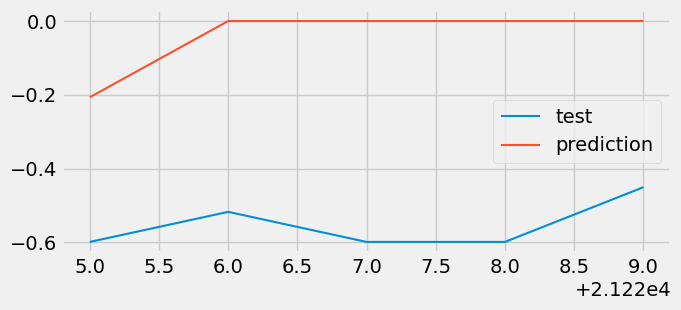

In [56]:
fig, ax = plt.subplots(figsize=(7, 3))
data_test['y'].plot(ax=ax, label='test')
predictions['prediction'].plot(ax=ax, label='prediction')
ax.legend();